In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [2]:
rng = np.random.seed(2741)
az.style.use("arviz-darkgrid")

In [3]:
try:
    d = pd.read_csv(os.path.join("..", "data", "body_fat.csv"))
except FileNotFoundError:
    d = pd.read_csv(pm.get_data("body_fat.csv"))

d.head()

,siri,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.3,23,70.1,172,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,78.8,184,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,70.0,168,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,84.0,184,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,83.8,181,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [4]:
with pm.Model() as model_0:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = alpha + beta * d["abdomen"]

    siri = pm.Normal("siri", mu=mu, sigma=sigma, observed=d["siri"])

    idata_0 = pm.sample(idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [siri]


Output()

In [5]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=3)
    sigma = pm.HalfNormal("sigma", 5)

    mu = alpha + pm.math.dot(beta, d[["wrist", "height", "weight"]].T)

    siri = pm.Normal("siri", mu=mu, sigma=sigma, observed=d["siri"])

    idata_1 = pm.sample(idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [siri]


Output()

In [6]:
model_dict = dict(zip(["model_0", "model_1"], [idata_0, idata_1]))
comp = az.compare(model_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_1,0,-817.205772,3.620469,0.000000,0.640128,10.509580,0.000000,False,log
model_0,1,-825.386844,1.912518,8.181071,0.359872,9.943596,8.696031,False,log


In [7]:
ppc_w = az.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)
ppc_w

Inference data with groups:
	> posterior_predictive
	> observed_data

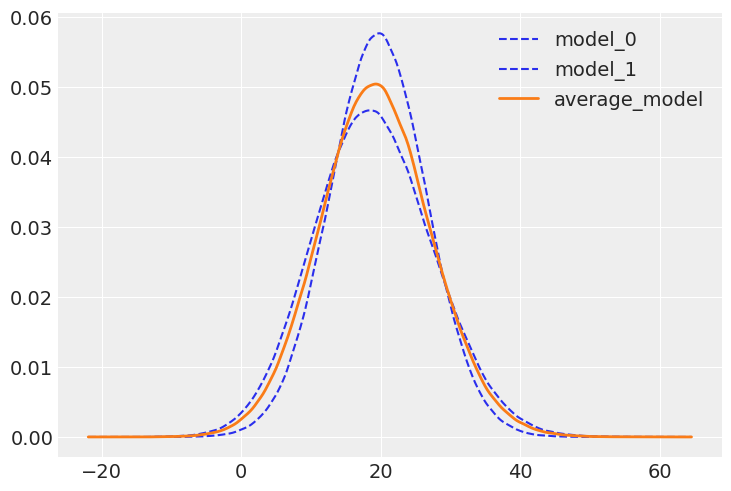

In [8]:
az.plot_kde(
    idata_0.posterior_predictive["siri"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="model_0",
)
az.plot_kde(
    idata_1.posterior_predictive["siri"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="model_1",
)
az.plot_kde(
    ppc_w.posterior_predictive["siri"].values,
    plot_kwargs={"color": "C1", "linewidth": 2},
    label="average_model",
);

In [9]:
idata_0

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data